## NOTES:
<ul>
<li>This notebook allows for further analysis of a single site and single metric from the dataset produced by aquifer analysis</li>
<li>The purpose is primarily for data validation, as well as further data visualization. This notebook also gives more insight into what each metric is measuring and what each column of the aquifer analyses data sets represents</li>
<li>Each metric can be run individually of any others, and are calculated using the same methods as in the aquifer analysis</li>
<li>As such, each metric is calculated independently here rather than relying on any data from any previous cells to ensure reliability</li>
</ul>

## CORE: Imports and Controls

In [22]:
# Imports -- Python 3.10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

# Custom libs
import Src.func as fn
import Src.classes as cl
reload(fn)
reload(cl)

pd.options.mode.chained_assignment = None

In [8]:
# Controls
# '11447650' -- SRB
site_no = '11447650'
df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=fn.DEFAULT_START, end=fn.DEFAULT_END)
data_range = 30 # 50-year period as this is the default tested against in validate()
quantile = 0.90 # 90% threshold as this is the first analyzed threshold in aquifer analysis

## METRIC: Valid
The `valid` column indicates whether a given site is missing no more than `MAX_MISSING_THRESHOLD` percent of its data across the analyzed range. For the purposes of this study `MAX_MISSING_THRESHOLD` is set to 10%.

Valid: True -- Missing 9.9989%


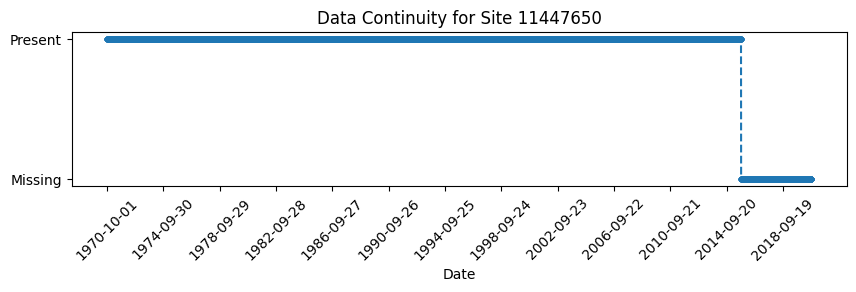

In [16]:
df_valid = df.reset_index()

# Set all present values to 1
start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_valid = df_valid[df_valid['datetime'].dt.date >= start]
df_valid['00060_Mean'] = 1 

# Validation using the predetermined start and end dates of (1970/90-2020)
missing = fn.validate(df_valid, start, fn.DEFAULT_END)
print(f"Valid: {missing < fn.MAX_MISSING_THRESHOLD} -- Missing {missing * 100:.4f}%")

# Create missing dates and set their values to 0
complete_range = pd.date_range(start=start, end=fn.DEFAULT_END, freq='D')
df_complete = pd.DataFrame({'datetime': complete_range})
df_valid = pd.concat([df_complete.set_index('datetime').tz_localize(None), df_valid.set_index('datetime').tz_localize(None)], axis=1, join='outer').fillna(0).reset_index()

plt.figure(figsize=(10, 2))
plt.plot(df_valid['datetime'], df_valid['00060_Mean'], marker='.', linestyle='dashed')

plt.yticks([0, 1], ['Missing', 'Present'])

plt.xticks(df_valid['datetime'][::(365*4)], rotation=45)
plt.xlabel("Date")

plt.title(f"Data Continuity for Site {site_no}")
plt.show()

## METRIC: Threshold
The `threshold` value is the flow value (ft<sup>3</sup>/s) above which any excess flow is considered high magnitude flow (HMF). This value is calculated as some quantile, 90% and 95% in the case of this study, of the total streamflow.

Threshold: 46200.0


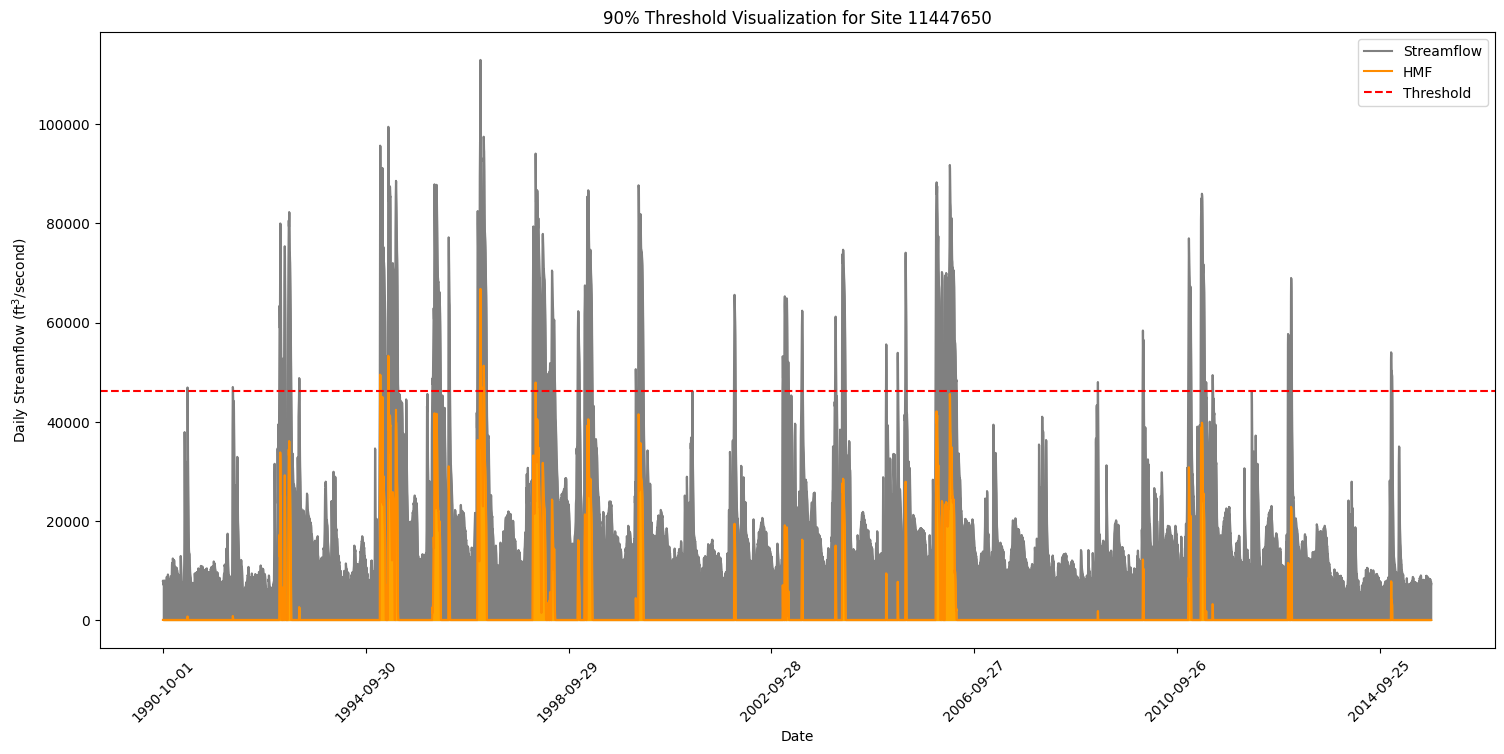

In [9]:
df_threshold = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threshold, quantile)
print(f"Threshold: {threshold}")

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

'''window = 50
df_threshold["00060_Mean"] = df_threshold["00060_Mean"].rolling(window=window).mean()
df_threshold["hmf"] = df_threshold["hmf"].rolling(window=window).mean()'''

plt.figure(figsize=(18, 8))
plt.plot(df_threshold["datetime"], df_threshold["00060_Mean"], label="Streamflow", color="gray")
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="darkorange")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_threshold["datetime"], df_threshold["00060_Mean"], color="gray")
plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*4)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}")
plt.legend()
plt.show()

## METRIC: HMF Years
The `hmf_years` column tracks the total number of hydrologic years over the analyzed range that saw any amount of HMF. 

HMF Years: 19


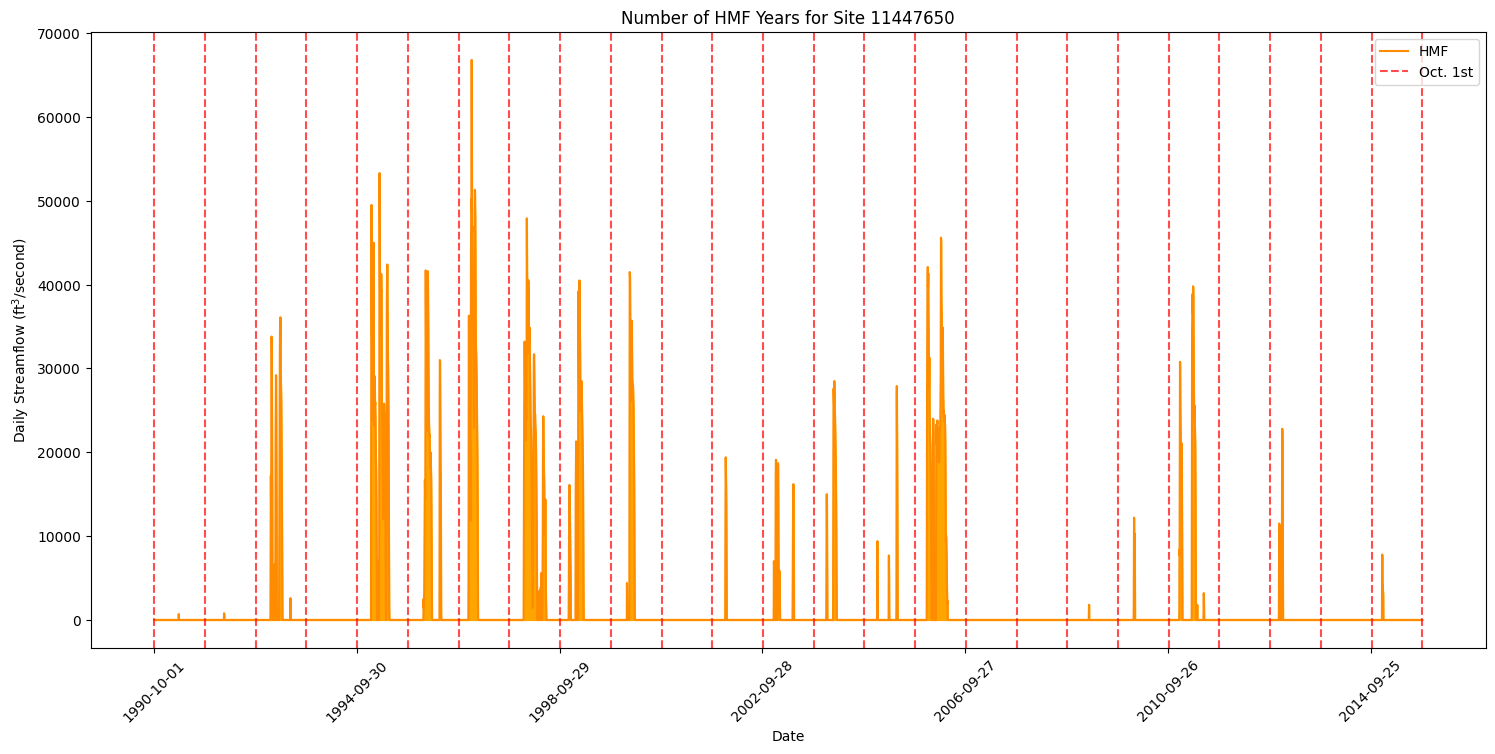

In [25]:
df_threshold = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threshold, quantile)
hmf_series, _ = fn.filter_hmf(df_threshold, threshold)
hmf_years = fn.num_hmf_years(hmf_series, 10)
print(f"HMF Years: {hmf_years}")

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

plt.figure(figsize=(18, 8))
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="darkorange")

first = True
for year in range(df_threshold["datetime"].dt.year.min(), df_threshold["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')
    
    if first:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7, label='Oct. 1st')
        first = False
    else:      
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7)

plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*4)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"Number of HMF Years for Site {site_no}")
plt.legend()
plt.show()

## METRIC: Annual HMF
The `annual_hmf` column holds the average amount of HMF, in km<sup>3</sup> per year.